In [9]:
import warnings
warnings.filterwarnings('ignore')
import pyterrier as pt
if not pt.started():
    pt.init()

import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
import glob
import ir_measures
from ir_measures import * # imports all supported measures, e.g., AP, nDCG, RR, P

In [10]:
# dataset_name = 'msmarco-passage'
# dataset = pt.get_dataset(f'irds:{dataset_name}')

dataset = pt.get_dataset(f'irds:msmarco-passage')
eval_dataset = pt.get_dataset(f'irds:msmarco-passage/dev')
topics = eval_dataset.get_topics()
# qrels = eval_dataset.get_qrels()

import ir_datasets
eval = ir_datasets.load("msmarco-passage/dev")
# topics = pd.DataFrame(eval.queries_iter())
qrels = pd.DataFrame(eval.qrels_iter())


In [11]:
qrels.shape

(59273, 4)

In [12]:
import tqdm
for qid in tqdm.tqdm(topics[:5]['qid']):
    print(type(qid))

100%|██████████| 5/5 [00:00<00:00, 87746.95it/s]

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [13]:
import json

def save(dict, file):
    with open(file,'w') as f:
        json.dump(dict, f)

def load(file):
    with open(file,'r') as f:
        ms_docids = json.load(f)
    return ms_docids

def Gini(v):
    v = np.array(v)
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = [0]
    for b in bins[1:]:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return gini_val

In [14]:
import statistics
def calc_stats(modelname,df, threshold, topics):
    scoredF = f'./results/{modelname}_docids_100_threshold_{threshold}.json'
    if not os.path.exists(scoredF):
        init_msmarco_dict = './results/ms_docids.json'
        docids_score = load(init_msmarco_dict)
        for qid in tqdm.tqdm(topics['qid']):
            D = df[df['qid'] == np.int64(qid)]
            for dno in D['docno']:
                rank = D[D['docno'] == dno]['rank'].values[0]
                score = 100 / np.log(rank + 2)  # plus 2 because the ranks start from zero
                docids_score[str(dno)] += score
        save(docids_score, scoredF)

    docids_score = load(scoredF)
    scores_df = pd.DataFrame.from_dict(docids_score, orient="index", columns=["score"])
    scores_df = scores_df[scores_df["score"] > 0]
    scores = scores_df['score'].to_list()

    mean = statistics.mean(scores)
    std_dev = statistics.stdev(scores)
    gini_value = Gini(scores)
    return mean, std_dev, gini_value

In [15]:
# def transform_df(df):
#     df_run = df.rename(columns={'qid':'query_id','docid':'doc_id'})
#     df_run[['query_id','doc_id']] = df_run[['query_id','doc_id']].astype(str)

#     return df_run


In [59]:
docids_score = load('./bm25_docids_100_threshold_60.json')

FileNotFoundError: [Errno 2] No such file or directory: './bm25_docids_100_threshold_60.json'

In [ ]:
scores_df = pd.DataFrame.from_dict(docids_score, orient="index", columns=["score"])
# scores_df.tail()

In [ ]:
scores_df = scores_df[scores_df["score"] > 0]
scores = scores_df['score'].to_list()
len(scores)

In [8]:
import glob
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_30*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_30_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_30_40000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_30_80000.csv


In [9]:
df.shape

(2109300, 5)

In [10]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

21093

In [11]:
calc_stats('colbert',df,30,topics)

100%|██████████| 101093/101093 [07:37<00:00, 221.01it/s]


(40.33003088412648, 28.226881905694416, 0.29293872545964966)

In [12]:
topics.shape

(101093, 2)

In [13]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [14]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.0737706373877901, nDCG@10: 0.08367249993447931}

In [22]:
import glob
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_90000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_40000.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_colbert_90_80000.csv


In [23]:
df.shape

(2109300, 5)

In [24]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

21093

In [25]:
calc_stats('colbert',df,90,topics)

100%|██████████| 101093/101093 [08:18<00:00, 202.94it/s]


(93.73061804189739, 86.13780265597373, 0.4223636245098966)

In [26]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [27]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.03239045863847885, nDCG@10: 0.035517682062096864}

In [15]:
res = pd.DataFrame()
for file in glob.glob('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_*.csv'):
    print(file)
    df = pd.concat([res,pd.read_csv(file,index_col=0).reset_index()],ignore_index=True)

/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_0.csv
/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_30_40000.csv


In [16]:
df.shape

(6108287, 5)

In [ ]:
grouped = df.groupby('qid')
len(grouped.groups.keys())

In [ ]:
calc_stats('bm25_colbert',df,30,topics)

In [ ]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [ ]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [17]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_30_.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_60_.csv', index_col=0).reset_index()

In [18]:
df.shape

(10108016, 5)

In [45]:
calc_stats('bm25_monot5',df,60,topics)

100%|██████████| 101093/101093 [44:12<00:00, 38.11it/s]


(115.48748108808213, 298.36146566735516, 0.47400568279596994)

In [46]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [47]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.2884650470819681, nDCG@10: 0.3190031825107953}

In [19]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_30_.csv', index_col=0).reset_index()
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_60_.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_monot5_90_.csv', index_col=0).reset_index()

In [20]:
df.shape

(10105728, 5)

In [49]:
calc_stats('bm25_monot5',df,90,topics)

100%|██████████| 101093/101093 [44:03<00:00, 38.24it/s]


(361.2086960062334, 855.9334992041702, 0.5108020525703535)

In [50]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [51]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1435522270533582, nDCG@10: 0.15535085729929}

In [ ]:

results_monot5_100.csv
results_splade_100.csv
results_colbert_100.csv
results_bm25_colbert_100.csv



In [43]:
import tqdm

In [56]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_30.csv', index_col=0).reset_index()

In [57]:
df.shape

(10109300, 5)

In [58]:
calc_stats('splade',df,30,topics)

100%|██████████| 101093/101093 [38:29<00:00, 43.76it/s]


(72.07897727079515, 67.02232864644255, 0.39601066004471325)

In [16]:
df = pd.read_csv('/nfs/datasets/cxj/retrievability-bias/results_splade_100.csv', index_col=0).reset_index()
calc_stats('splade',df,0,topics)

100%|██████████| 101093/101093 [41:26<00:00, 40.66it/s]


(62.1963154012954, 57.371235271423316, 0.38558389030795387)

In [54]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [55]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1521238468200753, nDCG@10: 0.16641022307449113}

In [23]:
# df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_30.csv', index_col=0).reset_index()
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_60.csv', index_col=0).reset_index()


In [24]:
df.shape

(10108016, 6)

In [57]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [58]:
calc_stats('bm25',df,60,topics)

100%|██████████| 101093/101093 [45:42<00:00, 36.86it/s]


(115.48748108808213, 334.4713511792268, 0.5019218174868961)

In [59]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.1770989985056333, nDCG@10: 0.20204167208954082}

In [25]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/bm25/df_bm25_90.csv', index_col=0).reset_index()

In [26]:
df.shape

(10105728, 6)

In [61]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [62]:
calc_stats('bm25',df,90,topics)

100%|██████████| 101093/101093 [45:46<00:00, 36.81it/s] 


(361.2086960062334, 953.8151508961946, 0.5383489669402687)

In [63]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

{RR: 0.09919385080888407, nDCG@10: 0.11094770042458738}

In [27]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_60_0.csv', index_col=0).reset_index()

In [28]:
df.shape

(10108016, 5)

In [65]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [66]:
calc_stats('bm25_colbert',df,60,topics)

100%|██████████| 101093/101093 [43:15<00:00, 38.95it/s]


(115.48748108808213, 299.2952445404816, 0.4757839359945219)

In [67]:
ir_measures.calc_aggregate([nDCG@10, RR], qrels, df2)

{RR: 0.2701930413241178, nDCG@10: 0.3012232637784799}

In [29]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/colbert/df_bm25_colbert_90_0.csv', index_col=0).reset_index()

In [30]:
df.shape

(10105728, 5)

In [69]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [70]:
calc_stats('bm25_colbert',df,90,topics)

100%|██████████| 101093/101093 [43:26<00:00, 38.79it/s]


(361.2086960062334, 868.2565808556265, 0.5122973596238822)

In [71]:
ir_measures.calc_aggregate([nDCG@10, RR], qrels, df2)

{RR: 0.13745628852665914, nDCG@10: 0.1497218020163707}

In [31]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_30.csv', index_col=0).reset_index()

In [32]:
df.shape

(10109300, 5)

In [ ]:

df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']

In [ ]:
df.head()

In [ ]:
calc_stats('splade',df,30,topics)

In [ ]:
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [33]:
df = pd.read_csv('/nfs/resources/cxj/retrievability-bias/splade/df_splade_60.csv', index_col=0).reset_index()


In [34]:
df.shape

(10109300, 5)

In [ ]:
df.head()

In [ ]:
calc_stats('splade',df,60,topics)

In [ ]:
df2 = pd.DataFrame()
df2['query_id'] = df['qid'].astype(str)
df2['doc_id'] = df['docno'].astype(str)
df2['score'] = df['score']
ir_measures.calc_aggregate([RR, nDCG@10], qrels, df2)

In [42]:
df = pd.read_csv('./results/expt_results.csv')
df = df.round(2)
print(df)

           Model  Gini  nDCG@10  Gini.1  nDCG@10.1  Gini.2  nDCG@10.2  Gini.3  \
0  BM25           0.48  0.21     0.47    0.22       0.50    0.20       0.54     
1  BM25>>Mono-T5  0.43  0.40     0.45    0.38       0.47    0.32       0.51     
2  Splade         0.39  0.45     0.40    0.42       0.41    0.35       0.41     
3  ColBERT        0.39  0.41     0.29    0.08       0.33    0.07       0.42     
4  BM25>>ColBERT  0.43  0.37     0.41    0.20       0.48    0.30       0.51     

   nDCG@10.3  
0  0.11       
1  0.16       
2  0.17       
3  0.04       
4  0.15       


In [43]:
x = [0, 30, 60, 90]

In [44]:
import matplotlib.pyplot as plt

In [45]:
gini_bm25 = df.loc[df['Model'] == 'BM25',['Gini','Gini.1','Gini.2','Gini.3']]
gini_monot5 = df.loc[df['Model'] == 'BM25>>Mono-T5',['Gini','Gini.1','Gini.2','Gini.3']]
gini_Splade = df.loc[df['Model'] == 'Splade',['Gini','Gini.1','Gini.2','Gini.3']]
gini_ColBERT = df.loc[df['Model'] == 'ColBERT',['Gini','Gini.1','Gini.2','Gini.3']]
gini_bm25_ColBERT = df.loc[df['Model'] == 'BM25>>ColBERT',['Gini','Gini.1','Gini.2','Gini.3']]

In [46]:
dfg_bm25 = df.loc[df['Model'] == 'BM25',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_monot5 = df.loc[df['Model'] == 'BM25>>Mono-T5',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_Splade = df.loc[df['Model'] == 'Splade',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_ColBERT = df.loc[df['Model'] == 'ColBERT',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]
dfg_bm25_ColBERT = df.loc[df['Model'] == 'BM25>>ColBERT',['nDCG@10','nDCG@10.1','nDCG@10.2','nDCG@10.3']]

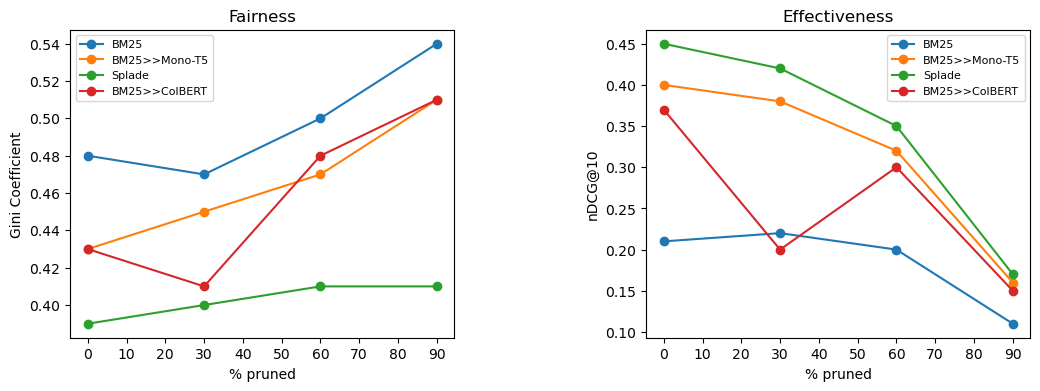

In [51]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=1, wspace=0.5, left=0.1)

y = gini_bm25.values[0]
ax1.plot(x,y,label='BM25', marker='o')
y = gini_monot5.values[0]
ax1.plot(x,y,label='BM25>>Mono-T5', marker='o')
y = gini_Splade.values[0]
ax1.plot(x,y,label='Splade', marker='o')
# y = gini_ColBERT.values[0]
# ax1.plot(x,y,label='ColBERT', marker='o')
y = gini_bm25_ColBERT.values[0]
ax1.plot(x,y,label='BM25>>ColBERT', marker='o')

ax1.set_title('Fairness')
ax1.set_xlabel('% pruned')
ax1.set_ylabel('Gini Coefficient')
ax1.set_xticks(ticks = [i for i in range(0,100,10)])
ax1.legend(fontsize=8)

y = dfg_bm25.values[0]
ax2.plot(x,y,label='BM25', marker='o')
y = dfg_monot5.values[0]
ax2.plot(x,y,label='BM25>>Mono-T5', marker='o')
y = dfg_Splade.values[0]
ax2.plot(x,y,label='Splade', marker='o')
# y = dfg_ColBERT.values[0]
# ax2.plot(x,y,label='ColBERT', marker='o')
y = dfg_bm25_ColBERT.values[0]
ax2.plot(x,y,label='BM25>>ColBERT', marker='o')

ax2.set_title('Effectiveness')
ax2.set_xlabel('% pruned')
ax2.set_ylabel('nDCG@10')
ax2.set_xticks(ticks = [i for i in range(0,100,10)])
ax2.legend(fontsize=8)

plt.savefig('./results/all_results.pdf', format="pdf", bbox_inches="tight", pad_inches=0.3)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

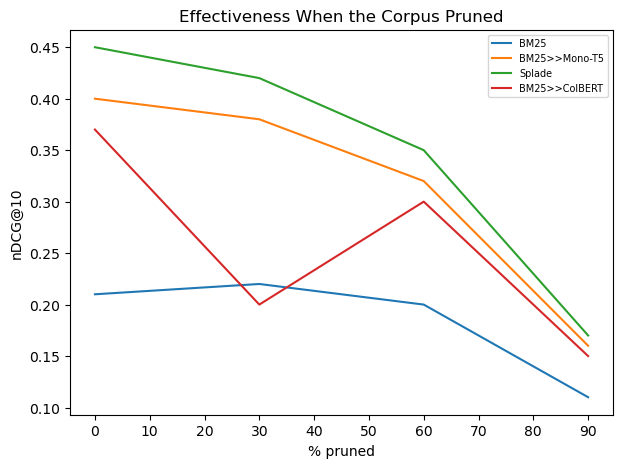

In [50]:
plt.figure(figsize=(7,5))
y = dfg_bm25.values[0]
plt.plot(x,y,label='BM25')
y = dfg_monot5.values[0]
plt.plot(x,y,label='BM25>>Mono-T5')
y = dfg_Splade.values[0]
plt.plot(x,y,label='Splade')
# y = dfg_ColBERT.values[0]
# plt.plot(x,y,label='ColBERT')
y = dfg_bm25_ColBERT.values[0]
plt.plot(x,y,label='BM25>>ColBERT')

plt.title('Effectiveness When the Corpus Pruned')
plt.xlabel('% pruned')
plt.ylabel('nDCG@10')
plt.xticks(ticks = [i for i in range(0,100,10)])
plt.legend(fontsize=7)
plt.show

In [ ]:
# df.plot(x='Gini', y='nDCG@10', kind='line', title='Sales Over Years',xlabel)

# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.lineplot(data=df, x='Gini', y='nDCG@10')
# plt.title('Sales Over Years')
# plt.ylabel('Sales (in Units)')
# plt.show()